In [1]:
import tensorflow 
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
tensorflow.keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

2025-10-16 02:16:19.218017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 02:16:19.260033: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 02:16:19.932379: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_augmentation = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,   
    height_shift_range=0.1 )
train_gen = train_augmentation.flow_from_directory(
        "/home/ocelot/Desktop/CNN_RPS/Archive/train",
        target_size=(100,150),
        batch_size=32,
        class_mode="sparse",
        color_mode="grayscale",
        seed=42

)

val_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    "/home/ocelot/Desktop/CNN_RPS/Archive/validation",
     target_size=(100,150),
     batch_size=32,
     class_mode="sparse",
     color_mode="grayscale",
     seed=42)

    

Found 1531 images belonging to 3 classes.
Found 438 images belonging to 3 classes.


In [3]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1 )
def create_model(learning_rate=0.001, conv_drop=0.25, dense_drop=0.5):
    model = tensorflow.keras.models.Sequential([
        layer.InputLayer(shape=(100,150,1)),
        layer.Conv2D(32, (3,3), activation='relu', padding='same'),
        layer.Conv2D(32, (3,3), activation='relu', padding='same'),
        layer.MaxPooling2D((2,2)),
        layer.Dropout(conv_drop),
        layer.Conv2D(64, (3,3), activation='relu', padding='same'),
        layer.Conv2D(64, (3,3), activation='relu', padding='same'),
        layer.MaxPooling2D((2,2)),
        layer.Dropout(conv_drop),
        layer.Conv2D(128, (3,3), activation='relu', padding='same'),
        layer.Conv2D(128, (3,3), activation='relu', padding='same'),
        layer.GlobalAveragePooling2D(),      
        layer.Dropout(dense_drop),
        layer.Dense(128, activation='relu'),
        layer.Dense(3, activation='softmax') ])
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model
              


In [4]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = KerasClassifier(model = create_model, epochs=15, verbose=0)
griglia = {
    "model__learning_rate": [1e-2, 1e-3, 5e-4, 1e-4],
    "model__conv_drop": [0.25, 0.3, 0.4],
    "model__dense_drop": [0.4, 0.5],
    #"batch_size": [32, 64]
}


kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=griglia,
    cv=kfold,               
    scoring='accuracy',         
    verbose=0,
    n_jobs=1 )

In [5]:
import os
import cv2
Im = []
target = []

cat = ["paper", "scissors", "rock"]
vettori = {"paper":0, "scissors":2, "rock":1}
for i in cat:
    for j in os.listdir(os.path.join("/home/ocelot/Desktop/CNN_RPS/Archive/train", i)):
        Im.append(cv2.imread(os.path.join("/home/ocelot/Desktop/CNN_RPS/Archive/train", i,j), 0))
        target.append(vettori[i])
X_train = np.array(Im).astype('float32') / 255.0
X_train = np.expand_dims(X_train, axis=-1)
Y_train = np.array(target)

In [ ]:
%%time
risultati = grid_search.fit(X_train, Y_train )

I0000 00:00:1760573784.734424 1024831 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13319 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-10-16 02:16:25.323554: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
E0000 00:00:1760573786.185953 1024831 meta_optimi

In [8]:
test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    "/home/ocelot/Desktop/CNN_RPS/Archive/test",
     target_size=(100,150),
     batch_size=32,
     class_mode="categorical",
     color_mode="grayscale",
     shuffle=False,
     seed=42)

Found 219 images belonging to 3 classes.


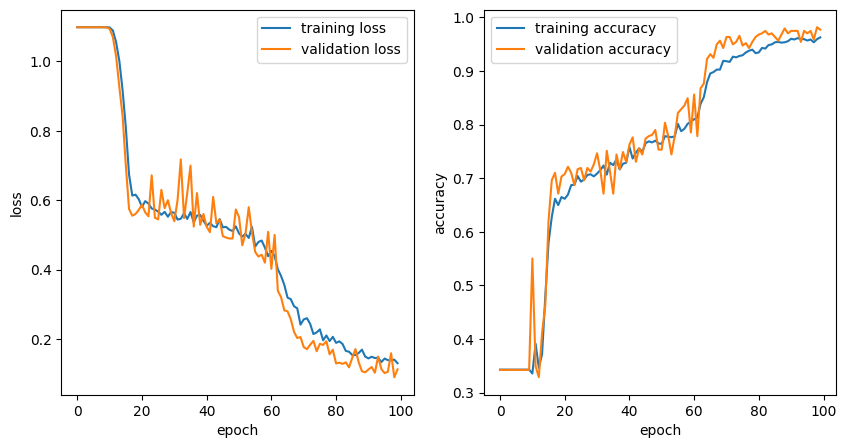

In [9]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].plot(history.history["loss"], label="training loss")
ax[0].plot(history.history["val_loss"], label="validation loss")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(history.history["accuracy"], label="training accuracy")
ax[1].plot(history.history["val_accuracy"], label="validation accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()

In [10]:
testLoss, testAccuracy = model.evaluate(test_gen)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9817 - loss: 0.0707


/home/ocelot/env/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
